In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines.utils import k_fold_cross_validation
from sklearn.model_selection import train_test_split

In [71]:
# Obtener la ruta absoluta del directorio actual (donde está el script o notebook)
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subimos un nivel

# Construir la ruta relativa a la carpeta "Datos"
ruta_bdd = os.path.join(base_dir, "Datos", "database.xlsx")

# Leer el archivo de datos
data = pd.read_excel(ruta_bdd, sheet_name=None)


In [72]:
# Concatenamos los dataframes de cada key:
data = pd.concat(data.values(), ignore_index=True)
print(data.shape)
data.head()

(41, 20)


,FECHA,Caudal,TPH,% Solido,Presion,Bateria,Ciclón,Medicion,horometro,camino_id,uso_230,TPH_acum,dias_230,solido_uso,carga_solidos_efectiva,ratio_tph_caudal,solido_presion,score,score_out,E
0,2019-03-18,3609.296448,4353.675418,70.596664,9.809577,BHC 1011,CyA,240.0,17987.828125,1011 CyA_2018-09-03,7.769185,17414.701673,196,805.053871,3505.532267,1.206239,692.523378,0.032372,0,1
1,2024-08-18,5618.364990,4718.561523,59.569263,10.484711,BHC 1011,CyB,233.5,50149.431641,1011 CyB_2024-07-31,5.004379,9437.123047,18,992.097028,1534.345463,0.839846,624.566522,0.021432,0,0
2,2017-11-07,3698.703006,4765.843759,70.589353,9.832086,BHC 1011,CyF,235.0,13588.043945,1011 CyF_2017-09-12,7.086742,9531.687517,56,872.902244,2019.102811,1.288518,694.040550,0.030156,0,0
3,2020-06-15,3689.816192,4116.444207,70.529620,9.718693,BHC 1011,CyG,240.0,25063.132812,1011 CyG_2019-10-08,8.229440,8232.888413,251,764.180942,1549.255011,1.115623,685.455732,0.034289,0,1
4,2024-09-10,4969.703509,4812.063802,63.001520,7.701962,BHC 1011,CyG,232.5,49058.373047,1011 CyG_2024-07-31,6.147913,14436.191406,41,881.397395,2356.554423,0.968280,485.235336,0.026443,0,0


In [73]:
data["E"].value_counts()

E
0    23
1    18
Name: count, dtype: int64

In [74]:
# Seleccionar las columnas relevantes para el modelo
formula_str = "uso_230 + TPH_acum + horometro"

# Definir pesos: Mayor peso para eventos (E=1), menor para censurados (E=0)
p_evento = data['E'].mean()  # Probabilidad de evento
data['peso'] = np.where(data['E'] == 1, 1 / p_evento, 1 / (1 - p_evento))

# Normalizar pesos para evitar valores extremos
data['peso'] = data['peso'] / data['peso'].mean()


# Ajustar el modelo de riesgos proporcionales de Cox
cph = CoxPHFitter()
cph.fit(data, duration_col="dias_230", event_col="E", weights_col="peso", formula = formula_str, robust=True)

# Mostrar el resumen del modelo
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 41 total observations, 20.5 right-censored observations>
             duration col = 'dias_230'
                event col = 'E'
              weights col = 'peso'
          robust variance = True
      baseline estimation = breslow
   number of observations = 41
number of events observed = 20.5
   partial log-likelihood = -40.11
         time fit was run = 2025-02-26 13:10:09 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
uso_230   -2.32      0.10      0.66           -3.63           -1.02                0.03                0.36
TPH_acum  -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
horometro -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

           cmp to     z      p  -log2(p)
covariate                               
uso_230      0.00 -3.49 <0.005     11.03
TPH_acum     0.00 -2.57   0.01      6.60
horometro    0.00 -2.15   0.03      4.99
---
Concordance = 0.86
Partial AIC = 86.21
log-likelihood ratio test = 26.36 on 3 df
-log2(p) of ll-ratio test = 16.93

### Evaluación

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from IPython.display import display

# ------------------------------------------------------------
# 1. Calcular pesos ajustados por censura
# ------------------------------------------------------------
# Definir pesos: Mayor peso para eventos (E=1), menor para censurados (E=0)

p_evento = data["E"].mean()  # Probabilidad de evento en el dataset
data["peso"] = np.where(data["E"] == 1, 1 / p_evento, 1 / (1 - p_evento))

# Normalizar los pesos para que su media sea 1 (evita valores extremos)
data["peso"] = data["peso"] / data["peso"].mean()

# ------------------------------------------------------------
# 2. Dividir datos en entrenamiento y prueba
# ------------------------------------------------------------
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# ------------------------------------------------------------
# 3. Ajustar el modelo de Cox en el set de entrenamiento con pesos y robust=True
# ------------------------------------------------------------
formula_str = "uso_230 + TPH_acum + horometro"  # Ajusta según tus covariables

cph = CoxPHFitter()
cph.fit(train_data, duration_col="dias_230", event_col="E", formula=formula_str, 
        weights_col="peso", robust=True)

print("Resumen del modelo Cox (con datos de entrenamiento):")
cph.print_summary()  # Coeficientes, p-valores, etc.

# ------------------------------------------------------------
# 4. Evaluar el desempeño en el set de prueba
# ------------------------------------------------------------
# 4.1. Calcular el riesgo parcial (hazard) para cada individuo en test
pred_risk = cph.predict_partial_hazard(test_data)

# 4.2. Calcular c-index para evaluar desempeño del modelo
c_index = concordance_index(
    event_times=test_data["dias_230"],
    predicted_scores=-pred_risk,  # En supervivencia, mayor riesgo implica menor tiempo de vida
    event_observed=test_data["E"]
)
print(f"\nC-index en el set de prueba: {c_index:.3f}")


Resumen del modelo Cox (con datos de entrenamiento):


<lifelines.CoxPHFitter: fitted with 32.4831 total observations, 14.2609 right-censored observations>
             duration col = 'dias_230'
                event col = 'E'
              weights col = 'peso'
          robust variance = True
      baseline estimation = breslow
   number of observations = 32.4831
number of events observed = 18.2222
   partial log-likelihood = -28.37
         time fit was run = 2025-02-26 13:10:24 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
uso_230   -3.38      0.03      0.46           -4.28           -2.49                0.01                0.08
TPH_acum  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
horometro -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

           cmp to     z      p  -log2(p)
covariate                               
uso_230      0.00 -7.40 <0.005     42.76
TPH_acum     0.00 -1.87   0.06      4.04
horometro    0.00 -2.31   0.02      5.59
---
Concordance = 0.90
Partial AIC = 62.75
log-likelihood ratio test = 29.94 on 3 df
-log2(p) of ll-ratio test = 19.42


C-index en el set de prueba: 1.000


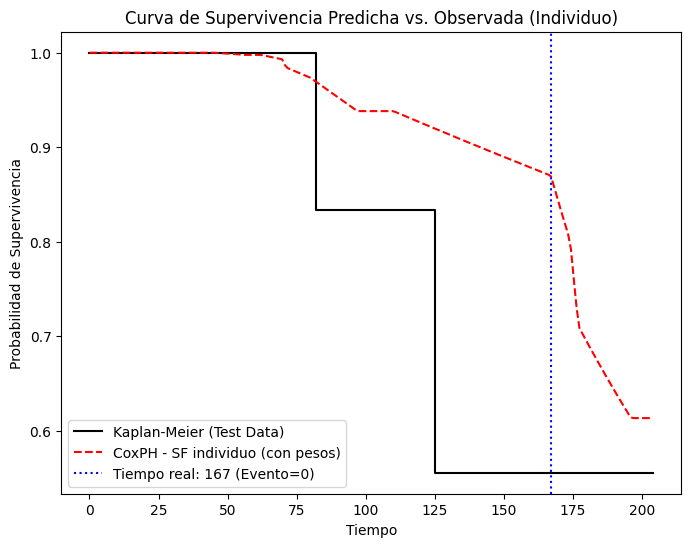


Predicciones (primeras 10 filas) con horizonte = 200 días:


,dias_230,E,uso_230,TPH_acum,horometro,pred_risk,surv_prob_200
24,118,0,7.522314,8852.344377,14855.285156,1.175361,2.083645e-03
13,70,0,6.812468,9225.063477,23005.978516,6.740293,4.210843e-16
8,82,1,6.884581,9697.078268,22316.537109,5.314855,7.516389e-13
25,125,1,7.357484,16364.229400,18128.314453,0.770556,1.746803e-02
4,41,0,6.147913,14436.191406,49058.373047,5.313104,7.585853e-13
40,167,0,7.918282,14011.408082,23988.646484,0.093055,6.133771e-01
19,79,0,5.620241,13966.142090,29355.204590,148.202718,0.000000e+00
39,97,0,7.504809,9319.372064,24245.939453,0.583831,4.657936e-02
29,204,0,7.684742,9428.542623,25128.562500,0.293840,2.136515e-01


In [76]:
# ------------------------------------------------------------
# 4. Presentar predicciones con modelo ajustado por pesos
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from IPython.display import display

RS = 150

# 4.1. Curva de supervivencia predicha para un individuo en test
sample_subject = test_data.sample(1, random_state=RS).copy()

# Información real del individuo
actual_time = sample_subject["dias_230"].values[0]
actual_event = sample_subject["E"].values[0]

# Rango de tiempos para graficar la función de supervivencia
tiempos = np.linspace(0, test_data["dias_230"].max(), 200)

# Curva de supervivencia predicha para el individuo usando el modelo Cox con pesos
sf_pred = cph.predict_survival_function(sample_subject, times=tiempos)

# Comparación con Kaplan-Meier (en todo el set de prueba)
kmf = KaplanMeierFitter()
kmf.fit(test_data["dias_230"], event_observed=test_data["E"])

plt.figure(figsize=(8,6))

# Curva Kaplan-Meier del set de prueba
plt.step(kmf.survival_function_.index,
         kmf.survival_function_["KM_estimate"],
         where="post", label="Kaplan-Meier (Test Data)", color="black")

# Curva de supervivencia ajustada con el modelo Cox con pesos
plt.plot(tiempos, sf_pred.iloc[:, 0],
         label="CoxPH - SF individuo (con pesos)", linestyle="--", color="red")

# Línea vertical en el tiempo real del individuo
plt.axvline(actual_time, color="blue", linestyle=":",
            label=f"Tiempo real: {actual_time} (Evento={actual_event})")

plt.title("Curva de Supervivencia Predicha vs. Observada (Individuo)")
plt.xlabel("Tiempo")
plt.ylabel("Probabilidad de Supervivencia")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 4.2. Tabla de predicciones para varios individuos con pesos
# ------------------------------------------------------------
# Definir un horizonte de tiempo para calcular la probabilidad de supervivencia
horizonte = 200
test_data = test_data.copy()  # Para evitar SettingWithCopyWarning

# Riesgo parcial ajustado por pesos
test_data["pred_risk"] = cph.predict_partial_hazard(test_data)

# Predicción de la supervivencia a un tiempo fijo para cada individuo
sf_200 = cph.predict_survival_function(test_data, times=[horizonte]).T
test_data[f"surv_prob_{horizonte}"] = sf_200.iloc[:, 0].values

# Mostrar las primeras filas con las predicciones ajustadas
print(f"\nPredicciones (primeras 10 filas) con horizonte = {horizonte} días:")
display(test_data[[ 
    "dias_230", "E", "uso_230", "TPH_acum", "horometro", "pred_risk", f"surv_prob_{horizonte}"
]].head(10))


Individuo seleccionado:


,FECHA,Caudal,TPH,% Solido,Presion,Bateria,Ciclón,Medicion,horometro,camino_id,...,TPH_acum,dias_230,solido_uso,carga_solidos_efectiva,ratio_tph_caudal,solido_presion,score,score_out,E,peso
4,2024-09-10,4969.703509,4812.063802,63.00152,7.701962,BHC 1011,CyG,232.5,49058.373047,1011 CyG_2024-07-31,...,14436.191406,41,881.397395,2356.554423,0.96828,485.235336,0.026443,0,0,0.891304


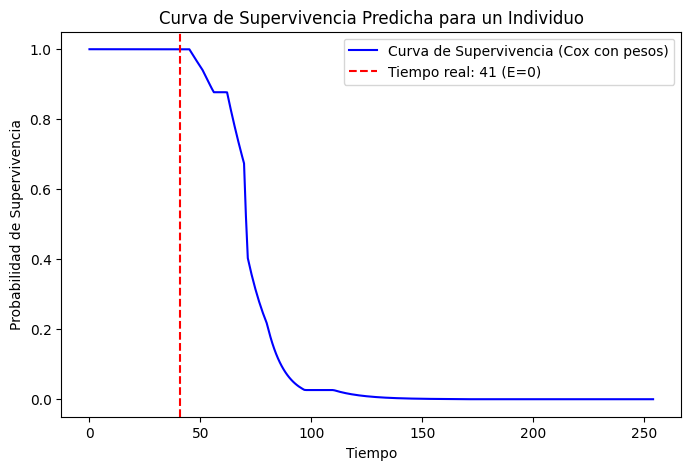


Resumen de la predicción para el individuo:


,real_time,real_event,pred_median,pred_mean
0,41,0,92.595318,72.233223


In [89]:
# ----------------------------------------------------------------------------
# 1. Calcular pesos ajustados por censura
# ----------------------------------------------------------------------------

RS = 17

# Mayor peso a eventos (E=1), menor a censurados (E=0)
p_evento = data["E"].mean()  # Probabilidad de evento en el dataset
data["peso"] = np.where(data["E"] == 1, 1 / p_evento, 1 / (1 - p_evento))

# Normalizar pesos para que la media sea 1 (evita valores extremos)
data["peso"] = data["peso"] / data["peso"].mean()

# ----------------------------------------------------------------------------
# 2. Dividir datos en entrenamiento y prueba
# ----------------------------------------------------------------------------
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# ----------------------------------------------------------------------------
# 3. Ajustar el modelo de Cox con pesos y robust=True
# ----------------------------------------------------------------------------
cph = CoxPHFitter()
cph.fit(train_data, duration_col="dias_230", event_col="E", formula="uso_230 + TPH_acum + horometro",
        weights_col="peso", robust=True)

# ----------------------------------------------------------------------------
# 4. Seleccionar un individuo del conjunto de prueba para ilustrar
# ----------------------------------------------------------------------------
sample_subject = test_data.sample(1, random_state=RS).copy()
real_time = sample_subject["dias_230"].values[0]
real_event = sample_subject["E"].values[0]

print("Individuo seleccionado:")
display(sample_subject)

# ----------------------------------------------------------------------------
# 5. Graficar la curva de supervivencia predicha con pesos
# ----------------------------------------------------------------------------
max_time = test_data["dias_230"].max() + 50  # Un poco más allá del tiempo máximo observado
time_grid = np.linspace(0, max_time, 300)

# Curva de supervivencia predicha para el individuo usando pesos
sf_pred = cph.predict_survival_function(sample_subject, times=time_grid)

plt.figure(figsize=(8,5))
plt.plot(time_grid, sf_pred.iloc[:, 0], label="Curva de Supervivencia (Cox con pesos)", color="blue")

# Línea vertical del tiempo real
plt.axvline(real_time, color="red", linestyle="--", label=f"Tiempo real: {real_time} (E={real_event})")

plt.xlabel("Tiempo")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curva de Supervivencia Predicha para un Individuo")
plt.legend()
plt.show()

# ----------------------------------------------------------------------------
# 6. Calcular el tiempo mediano y la esperanza de vida aproximada
# ----------------------------------------------------------------------------
sf_values = sf_pred.iloc[:, 0].values  # Prob. de supervivencia en cada t

# 6.1. Tiempo mediano: t donde S(t) cruza 0.5
median_time_candidates = time_grid[sf_values <= 0.05]
median_time = median_time_candidates[0] if len(median_time_candidates) > 0 else np.nan

# 6.2. Tiempo medio (esperanza de vida): integral de la curva de supervivencia
mean_time_approx = np.trapz(sf_values, time_grid)

# ----------------------------------------------------------------------------
# 7. Presentar los resultados en una tabla
# ----------------------------------------------------------------------------
result_dict = {
    "real_time": real_time,
    "real_event": real_event,
    "pred_median": median_time,
    "pred_mean": mean_time_approx
}
result_df = pd.DataFrame([result_dict])

print("\nResumen de la predicción para el individuo:")
display(result_df)


In [87]:
np.exp(sample_subject["uso_230"])

4    467.740234
Name: uso_230, dtype: float64

## Cross-Validation

### k-fold (5 folds)

In [48]:
from lifelines.utils import k_fold_cross_validation

# Seleccionar solo las columnas que usa el modelo
df_model = data[["dias_230", "E", "uso_230", "TPH_acum", "horometro"]].copy()

cph = CoxPHFitter()

cindex_scores = k_fold_cross_validation(
    cph, 
    df_model, 
    duration_col="dias_230", 
    event_col="E", 
    k=5, 
    scoring_method="concordance_index"
)

print("C-index para cada fold:", cindex_scores)
print("C-index promedio:", np.mean(cindex_scores))


C-index para cada fold: [0.7894736842105263, 1.0, 1.0, 1.0, 0.8181818181818182]
C-index promedio: 0.921531100478469


### Integrated Brier Score

In [62]:
from sklearn.model_selection import KFold
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from sksurv.util import Surv

# Convertir el DataFrame a una estructura adecuada para scikit-survival
# Suponiendo que "dias_230" y "E" son las columnas en tu DataFrame
y_struct = Surv.from_dataframe("E", "dias_230", data)
X = data[["uso_230", "TPH_acum", "horometro"]].values

cv = KFold(n_splits=5, shuffle=True, random_state=60)
ibs_scores = []

for train_idx, test_idx in cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_struct[train_idx], y_struct[test_idx]
    
    # Entrenar el modelo en el fold de entrenamiento
    model = CoxPHSurvivalAnalysis()
    model.fit(X_train, y_train)
    
    # Definir la cuadrícula de tiempos usando el dominio del conjunto de entrenamiento
    min_time_train = np.min(y_train["dias_230"])
    max_time_train = np.max(y_train["dias_230"])
    time_grid_fold = np.linspace(min_time_train, max_time_train, 100)
    
    # Obtener las funciones de supervivencia para los individuos del conjunto de prueba
    surv_funcs = [fn(time_grid_fold) for fn in model.predict_survival_function(X_test)]
    
    # Calcular el Integrated Brier Score para este fold
    ibs = integrated_brier_score(y_train, y_test, surv_funcs, time_grid_fold)
    ibs_scores.append(ibs)

print("Integrated Brier Score para cada fold:", ibs_scores)
print("Integrated Brier Score promedio:", np.mean(ibs_scores))


ValueError: all times must be within follow-up time of test data: [16.0; 292.0[

In [61]:
y_train

array([( True, 196.), (False,  56.), ( True, 251.), (False,  41.),
       ( True,  70.), ( True, 174.), ( True,  82.), ( True,  80.),
       ( True,  70.), ( True,  51.), ( True, 292.), (False, 110.),
       (False,  56.), (False, 204.), (False,  79.), (False,  42.),
       ( True,  56.), ( True,  97.), (False,  16.), (False, 118.),
       ( True, 125.), ( True, 356.), (False, 230.), (False,  56.),
       ( True, 260.), ( True, 177.), (False, 204.), (False,  62.),
       ( True,  70.), (False,  62.), ( True,  97.), (False, 204.),
       (False,  45.), ( True, 167.), (False,  97.), (False, 167.)],
      dtype=[('E', '?'), ('dias_230', '<f8')])

In [58]:
max_time

385.0

In [57]:
time_grid_fold

array([ 18.        ,  21.60606061,  25.21212121,  28.81818182,
        32.42424242,  36.03030303,  39.63636364,  43.24242424,
        46.84848485,  50.45454545,  54.06060606,  57.66666667,
        61.27272727,  64.87878788,  68.48484848,  72.09090909,
        75.6969697 ,  79.3030303 ,  82.90909091,  86.51515152,
        90.12121212,  93.72727273,  97.33333333, 100.93939394,
       104.54545455, 108.15151515, 111.75757576, 115.36363636,
       118.96969697, 122.57575758, 126.18181818, 129.78787879,
       133.39393939, 137.        , 140.60606061, 144.21212121,
       147.81818182, 151.42424242, 155.03030303, 158.63636364,
       162.24242424, 165.84848485, 169.45454545, 173.06060606,
       176.66666667, 180.27272727, 183.87878788, 187.48484848,
       191.09090909, 194.6969697 , 198.3030303 , 201.90909091,
       205.51515152, 209.12121212, 212.72727273, 216.33333333,
       219.93939394, 223.54545455, 227.15151515, 230.75757576,
       234.36363636, 237.96969697, 241.57575758, 245.18

### Distribución del error medio y mediano

In [39]:
# Dividir datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=60)

# Ajustar el modelo de Cox en el conjunto de entrenamiento
cph = CoxPHFitter()
cph.fit(train_data, duration_col="dias_230", event_col="E", formula="uso_230 + TPH_acum + horometro")

# ----------------------------------------------------------------------------
# 2. Seleccionamos los individuos con E = 1 (evento) en el set de prueba
# ----------------------------------------------------------------------------
# Filtrar los individuos con E=1 en test
event_subjects = test_data[test_data["E"] == 1].copy()

real_time = event_subjects["dias_230"].values
real_event = event_subjects["E"].values


# ----------------------------------------------------------------------------
# 3. Predecir la curva de supervivencia para los individuos con E=1
# ----------------------------------------------------------------------------
# Definir un rango de tiempos para evaluar la supervivencia
max_time = test_data["dias_230"].max() + 50  # Un poco más allá del tiempo máximo observado
time_grid = np.linspace(0, max_time, 300)

# Curva de supervivencia predicha para el individuo
sf_pred = cph.predict_survival_function(event_subjects, times=time_grid)

# ----------------------------------------------------------------------------
# 4. Calcular el tiempo mediano y la esperanza de vida aproximada
# ----------------------------------------------------------------------------
median_time_list = []
mean_time_list = []
for subject in range(sf_pred.shape[1]):
    sf_values = sf_pred.iloc[:, subject].values  # Prob. de supervivencia en cada t
    # 4.1. Tiempo mediano: t donde S(t) cruza 0.5
    median_time_candidates = time_grid[sf_values <= 0.5]
    if len(median_time_candidates) == 0:
        median_time = np.nan  # No cruza 0.5, prob. de supervivencia > 0.5 en todo el rango
    else:
        median_time = median_time_candidates[0]  # Primer punto donde S(t) <= 0.5

    # 4.2. Tiempo medio: integral de la curva de supervivencia
    # Aproximamos con la regla trapezoidal
    mean_time_approx = np.trapz(sf_values, time_grid)

    median_time_list.append(median_time)
    mean_time_list.append(mean_time_approx)

# ----------------------------------------------------------------------------
# 5. Presentar los resultados en una tabla
# ----------------------------------------------------------------------------
result_dict = {
    "real_time": real_time,
    "real_event": real_event,
    "pred_median": median_time_list,
    "pred_mean": mean_time_list
}
result_df = pd.DataFrame(result_dict)

print("\nResumen de la predicción para los individuos:")
display(result_df)


Resumen de la predicción para los individuos:


,real_time,real_event,pred_median,pred_mean
0,356,1,301.304348,342.400038
1,97,1,118.695652,110.530299
2,496,1,NaN,510.405096
3,51,1,80.347826,75.318615
